# equation generation - build_derivs
An atomsim function for generating the von Neumann ODE system to be passed to a numerical solver, given a specified Hamiltonian.

In [1]:
#### modules
import numpy as np
from sympy import MatrixSymbol,MatMul,Matrix,symbols,Function
from sympy.utilities.lambdify import lambdify
import sympy as sp
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import time

#### local classes
from physconsts import hbar

#### the derivative generator itself
from atomsim import build_derivs

## ex. 1: time-independent fields

In [2]:
# here's how to build the ODE system from a Hamiltonian  

O1 = O2 = 1
D = 10 # detuning much greater than Rabi freq

H = hbar*Matrix([[0,O1/2,0],[O1/2,-D,O2/2],[0,O2/2,0]]) # RWA

derivs = build_derivs(H, showeqs=True)

Equations: 

D[r00] = -9.48252172113838e+33*I*(5.272859e-35*r01 - 5.272859e-35*conjugate(r01))

D[r01] = -9.48252172113838e+33*I*(5.272859e-35*r00 - 1.0545718e-33*r01 + 5.272859e-35*r02 - 5.272859e-35*r11)

D[r02] = -9.48252172113838e+33*I*(5.272859e-35*r01 - 5.272859e-35*r12)

D[r11] = -9.48252172113838e+33*I*(-5.272859e-35*r01 + 5.272859e-35*r12 + 5.272859e-35*conjugate(r01) - 5.272859e-35*conjugate(r12))

D[r12] = -9.48252172113838e+33*I*(-5.272859e-35*r02 + 5.272859e-35*r11 + 1.0545718e-33*r12 - 5.272859e-35*r22)

D[r22] = -9.48252172113838e+33*I*(-5.272859e-35*r12 + 5.272859e-35*conjugate(r12))



In [3]:
# solve the system

# unraveled non-redundant density matrix elements
r0 = np.zeros(6, dtype=complex) 
r0[0] = 1+0j # start in groundstate

t_exp = 124 # units lifetime maybe

t0 = time.time()
soln = solve_ivp(derivs,[0,t_exp],r0)
print(f"completed in {(time.time()-t0)*1000} ms")

completed in 354.08663749694824 ms


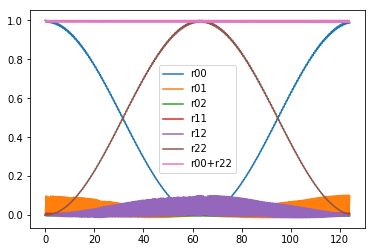

In [4]:
# plot it
for i,var in zip(range(len(r0)), ['r00','r01','r02','r11','r12','r22']):
    plt.plot(soln.t,np.real(soln.y[i]), label=var)
plt.plot(soln.t, np.real(soln.y[0]+soln.y[-1]),label="r00+r22")
plt.legend(loc='best')

## ex. 2: time-dependent fields

In [5]:
# build completely generic eqs; good for checking what your 
# equations look like. the deriv builder will work just fine with 
# this, but the solver will obviously not be able to solve the derivs 
# function.

# symbolic time varying fields and detunings
O1 = Function('O1')('t') 
O2 = Function('O2')('t')
D = Function('D')('t')

# could define fields after this if desired.  

# note that i did not use sympy Symbols for O1, O2, and D. This has to
# do with the way I am printing the equations; I could change this in
# the future.

# hbar will cancel out in the eqs
H = hbar*Matrix([[0,O1/2,0],[O1/2,-D,O2/2],[0,O2/2,0]])

derivs = build_derivs(H, showeqs=True)

Equations: 

D[r00] = -9.48252172113838e+33*I*(5.272859e-35*r01*O1(t) - 5.272859e-35*O1(t)*conjugate(r01))

D[r01] = -9.48252172113838e+33*I*(5.272859e-35*r00*O1(t) - 1.0545718e-34*r01*D(t) + 5.272859e-35*r02*O2(t) - 5.272859e-35*r11*O1(t))

D[r02] = -9.48252172113838e+33*I*(5.272859e-35*r01*O2(t) - 5.272859e-35*r12*O1(t))

D[r11] = -9.48252172113838e+33*I*(-5.272859e-35*r01*O1(t) + 5.272859e-35*r12*O2(t) + 5.272859e-35*O1(t)*conjugate(r01) - 5.272859e-35*O2(t)*conjugate(r12))

D[r12] = -9.48252172113838e+33*I*(-5.272859e-35*r02*O1(t) + 5.272859e-35*r11*O2(t) + 1.0545718e-34*r12*D(t) - 5.272859e-35*r22*O2(t))

D[r22] = -9.48252172113838e+33*I*(-5.272859e-35*r12*O2(t) + 5.272859e-35*O2(t)*conjugate(r12))

